In [1]:
import sys
import os
from pathlib import Path

sys.path.append(os.path.abspath(".."))

import torch
import numpy as np
import umap
import matplotlib.pyplot as plt


from utils.data import (
    download_mnist_data,
    get_mnist_image_np_arrays,
    get_mnnist_labels_np_arrays,
    UMAPImageDataset,
)
from utils.autoencoder import MNISTAutoencoder
from utils.loss import UMAPAutoencoderLoss
from utils.train_functions import (
    train_autoencoder,
    train_autoencoder_with_umap,
    test_autoencoder_reconstruction,
    test_autoencoder_umap_embedding,
)

In [2]:
# Download MNIST data if not already present
download_mnist_data()

train_images, test_images = get_mnist_image_np_arrays()
# Labels for visualization purposes
train_labels, test_labels = get_mnnist_labels_np_arrays()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 22.0M  100 22.0M    0     0  11.9M      0  0:00:01  0:00:01 --:--:-- 25.4M


Unzipping dataset...
Deleting zip...
Done


In [ ]:
embedding_dim = 2

full_images = np.concatenate([train_images, test_images], axis=0)
flat_full_images = full_images.reshape(full_images.shape[0], -1)
reducer = umap.UMAP(n_components=embedding_dim)
full_embeddings = reducer.fit_transform(flat_full_images)

train_embeddings = full_embeddings[: len(train_images)]
test_embeddings = full_embeddings[len(train_images) :]

# Save full embeddings to a file
project_dir = Path("..").resolve()
embeddings_file = (
    project_dir
    / "data"
    / "mnist"
    / "umap_embeddings"
    / f"embeddings_d{embedding_dim}.npy"
)
embeddings_file.parent.mkdir(parents=True, exist_ok=True)
np.save(embeddings_file, full_embeddings)

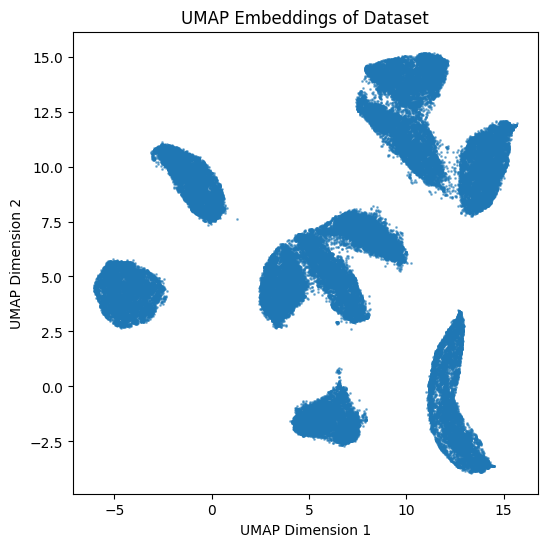

In [4]:
# Plot embeddings
plt.figure(figsize=(6, 6))
plt.scatter(full_embeddings[:, 0], full_embeddings[:, 1], s=1, alpha=0.5)
plt.title("UMAP Embeddings of Dataset")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()

In [5]:
print(train_images.shape, train_labels.shape)

(60000, 28, 28) (60000, 10)


In [37]:
from sklearn.mixture import GaussianMixture

Y = full_embeddings


for k in [12]:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        max_iter=500,
        random_state=42,
    ).fit(Y)
    print(k, gmm.score(Y))


12 -4.6064


In [38]:
num_samples = 2000
Y_fake, _ = gmm.sample(num_samples)
# Y_fake shape = (2000, 2)

/home/nacho/code/GI/umap-autoencoder/.venv/lib/python3.11/site-packages/sklearn/mixture/_base.py:443: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  rng.multivariate_normal(mean, covariance, int(sample))


In [34]:
# Datasets
flat_train_images = train_images.reshape(train_images.shape[0], -1)
flat_test_images = test_images.reshape(test_images.shape[0], -1)

train_embeddings = full_embeddings[: len(train_images)]
test_embeddings = full_embeddings[len(train_images) :]

flat_train_dataset = UMAPImageDataset(
    images=flat_train_images, umap_embeddings=train_embeddings
)
flat_test_dataset = UMAPImageDataset(
    images=flat_test_images, umap_embeddings=test_embeddings
)

flat_train_loader = torch.utils.data.DataLoader(
    flat_train_dataset, batch_size=128, shuffle=False
)
flat_test_loader = torch.utils.data.DataLoader(
    flat_test_dataset, batch_size=128, shuffle=False
)

In [11]:
autoencoder_input_dim = flat_full_images.shape[1]
umap_autoencoder = MNISTAutoencoder(
    input_dim=autoencoder_input_dim, embedding_dim=embedding_dim
)

umap_criterion = UMAPAutoencoderLoss(reconstruction_weight=0.5, umap_weight=0.5)
umap_optimizer = torch.optim.Adam(umap_autoencoder.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

umap_num_epochs = 50

train_autoencoder_with_umap(
    model=umap_autoencoder,
    dataloader=flat_train_loader,
    criterion=umap_criterion,
    optimizer=umap_optimizer,
    num_epochs=umap_num_epochs,
    device=device,
)


Epoch [1/50], Loss: 3.3688
Epoch [2/50], Loss: 0.9292
Epoch [3/50], Loss: 0.6267
Epoch [4/50], Loss: 0.4901
Epoch [5/50], Loss: 0.3926
Epoch [6/50], Loss: 0.3206
Epoch [7/50], Loss: 0.2680
Epoch [8/50], Loss: 0.2277
Epoch [9/50], Loss: 0.1936
Epoch [10/50], Loss: 0.1675
Epoch [11/50], Loss: 0.1518
Epoch [12/50], Loss: 0.1374
Epoch [13/50], Loss: 0.1350
Epoch [14/50], Loss: 0.1392
Epoch [15/50], Loss: 0.1201
Epoch [16/50], Loss: 0.1058
Epoch [17/50], Loss: 0.1013
Epoch [18/50], Loss: 0.1065
Epoch [19/50], Loss: 0.1192
Epoch [20/50], Loss: 0.0997
Epoch [21/50], Loss: 0.0855
Epoch [22/50], Loss: 0.0788
Epoch [23/50], Loss: 0.0747
Epoch [24/50], Loss: 0.0723
Epoch [25/50], Loss: 0.0724
Epoch [26/50], Loss: 0.0707
Epoch [27/50], Loss: 0.0690
Epoch [28/50], Loss: 0.0719
Epoch [29/50], Loss: 0.0754
Epoch [30/50], Loss: 0.0748
Epoch [31/50], Loss: 0.0906
Epoch [32/50], Loss: 0.0930
Epoch [33/50], Loss: 0.0703
Epoch [34/50], Loss: 0.0578
Epoch [35/50], Loss: 0.0505
Epoch [36/50], Loss: 0.0476
E

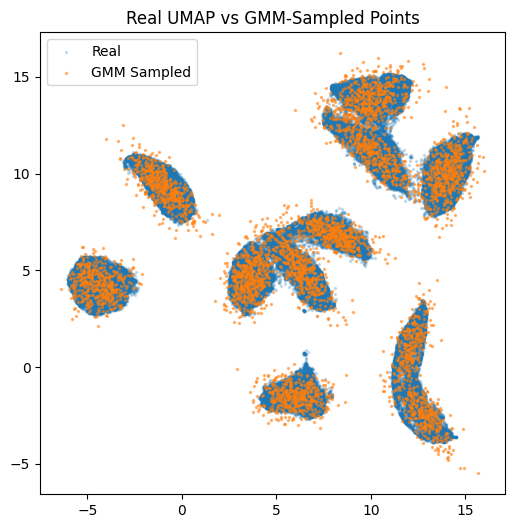

In [39]:
# Generate synthetic UMAP points
Y_fake, _ = gmm.sample(5000)

plt.figure(figsize=(6,6))
plt.scatter(Y[:,0], Y[:,1], s=2, alpha=0.2, label="Real")
plt.scatter(Y_fake[:,0], Y_fake[:,1], s=2, alpha=0.5, label="GMM Sampled")
plt.legend()
plt.title("Real UMAP vs GMM-Sampled Points")
plt.show()


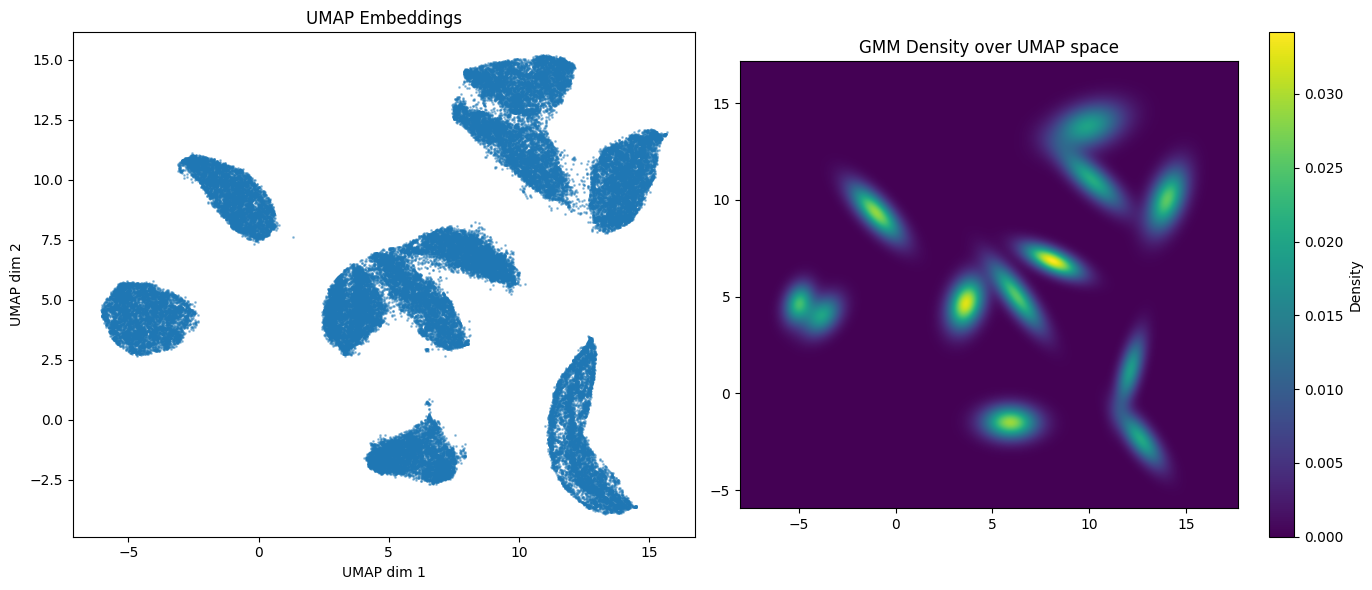

In [40]:
import matplotlib.pyplot as plt

# === Precompute density once ===
x = np.linspace(Y[:,0].min()-2, Y[:,0].max()+2, 500)
y = np.linspace(Y[:,1].min()-2, Y[:,1].max()+2, 500)
xx, yy = np.meshgrid(x, y)
grid = np.column_stack([xx.ravel(), yy.ravel()])
log_density = gmm.score_samples(grid)
density = np.exp(log_density).reshape(500, 500)

# === Create combined figure ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ---- LEFT: UMAP scatter ----
axes[0].scatter(Y[:,0], Y[:,1], s=1, alpha=0.4)
axes[0].set_title("UMAP Embeddings")
axes[0].set_xlabel("UMAP dim 1")
axes[0].set_ylabel("UMAP dim 2")

# ---- RIGHT: GMM density ----
im = axes[1].imshow(
    density,
    extent=(x.min(), x.max(), y.min(), y.max()),
    origin='lower',
    cmap='viridis'
)
axes[1].set_title("GMM Density over UMAP space")

# shared colorbar for density
fig.colorbar(im, ax=axes[1], label="Density")

plt.tight_layout()
plt.show()



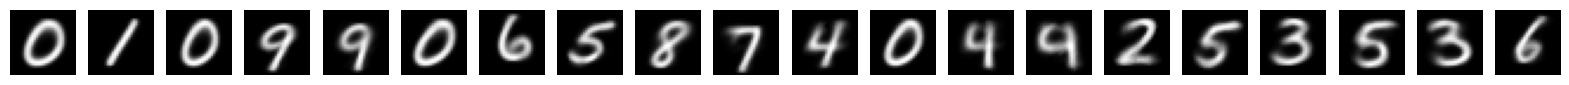

In [41]:
# Decode synthetic UMAP points
synthetic_images = (
    umap_autoencoder.decoder(
        torch.tensor(Y_fake, dtype=torch.float32).to(device)
    )
    .cpu()
    .detach()
    .numpy()
)

synthetic_images = synthetic_images.reshape(-1, 28, 28)

# Plot
n = 20
plt.figure(figsize=(20, 4))
idxs = np.random.choice(synthetic_images.shape[0], n, replace=False)
for i, idx in enumerate(idxs):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(synthetic_images[idx], cmap="gray")
    plt.axis("off")
plt.show()
